In [2]:
# 1 Import libraries + custom functions

import numpy as np
from utils import filename_from_path
from keras.models import Sequential
from keras.optimizers import *
from keras.regularizers import l2
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from skimage.io import imread
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
import keras
import glob
import platform
from datetime import datetime
import pickle

def reshape_to_view_img(img):
    (x,y) = (img.shape[0],img.shape[1])
    return np.reshape(img,(x,-1,))

def filename_from_path(path):
    return path.split('/')[-1]

In [3]:
#verify GPU is up n running
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14616508283506073230
]


In [4]:
# 2 Load data + initialize variables

train_labels = pd.read_csv('train_onelabel.csv',index_col='image')
get_class_of = train_labels['class'].to_dict()                                             #dict image->class
get_images_of = train_labels.groupby('class').apply(lambda x: x.values.tolist()).to_dict() #dict ???

input_size = (64, 64)
output_size = len(list(train_labels['class'].unique()))

label_map = pd.read_csv('label_map.txt',header=None,names=['name','id'],sep=' ')
get_name_of_class = label_map['name'].to_dict()
''' get_name_of_class[9] >> 'ctenophore_cydippid_tentacles' '''
get_class_name_of = {v: k for k, v in get_name_of_class.items()}
''' get_class_name_of['ctenophore_cydippid_tentacles'] >> 9 '''

training_paths_list = glob.glob('competition_data/train_images/*')     #normal (not numpy) list of str  
test_set_list = glob.glob('competition_data/test_images/*')          #normal (not numpy) list of str 

# savedmodelpath = 'trainHistory/12-08 18.54, train_err=0.70, test_err=0.73double_kernel_size_termatismeno.h5'

np.random.seed(123)  # for reproducibility

#model parameters

batch_size=64
reg_lambda = 0.01/255
dropout_value=0.25

#handle imbalanced classes

#Read training data

class_counts = train_labels['class'].value_counts()
class_weights = 1/np.log(class_counts)
#class_weights = class_weights.to_dict()

In [5]:
# 3 Load & Preprocess input data

def inverse_grayscale(pixel_value):
    return (255.-pixel_value)
def inverse_scale_center(pixel_value):
    return (((255.-pixel_value)/255)-0.5)
v_inverse_grayscale = np.vectorize(inverse_grayscale)
v_inverse_scale_center = np.vectorize(inverse_scale_center)

input_size = (64,64)      # ! parameter
training_images = (load_img(p, target_size=input_size, grayscale=True) for p in training_paths_list)
traning_images_array = np.array([img_to_array(im) for im in training_images]) #numpy array of numpy arrays (pictures) (X_train)
del training_images

test_images = (load_img(p, target_size=input_size,grayscale=True) for p in test_set_list)
test_images_array = np.array([img_to_array(im) for im in test_images])
del test_images

if (platform.system()=='Windows'):
    all_labels = list(map(lambda p: get_class_of[p.split('\\')[-1]] , training_paths_list))
else:
    all_labels = list(map(lambda p: get_class_of[p.split('/')[-1]] , training_paths_list))

traning_images_array = v_inverse_scale_center(traning_images_array)   #apply inverse grayscale transformation before splitting to train+validation
test_images_array = v_inverse_scale_center(test_images_array)         #apply inverse grayscale transformation to test data as well

#We will take ALL images for the final training - normally we split 80-20 (train-validation)
# traning_images_array, validation_images_array, train_labels , validation_labels = train_test_split(traning_images_array, 
#                                                                                                    to_categorical(all_labels), 
#                                                                                                    stratify=to_categorical(all_labels), 
#                                                                                                    test_size=0.2, random_state=41)

#split training and cross validation data

traning_images_array = traning_images_array.astype('float32')
# validation_images_array = validation_images_array.astype('float32')
test_images_array = test_images_array.astype('float32')

In [6]:
# Image Augmentation
train_datagen = ImageDataGenerator(rotation_range=90,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                    samplewise_std_normalization=False,
                                    samplewise_center=False,
                                   #rescale=1./255.,
                                   #zca_whitening=True,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.1,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = (20/360)*(2*np.pi)
                                )


# valid_datagen = ImageDataGenerator(
#             featurewise_center=True,
#             featurewise_std_normalization=True,
#             samplewise_std_normalization=False,
#             samplewise_center=False,
#         )


test_datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            samplewise_std_normalization=False,
            samplewise_center=False,
        )


train_datagen.fit(traning_images_array)    #used for zca whitening/featurewise_center & normalization
# valid_datagen.fit(validation_images_array)
test_datagen.fit(test_images_array)

In [7]:
# 4 Define model architecture

model = Sequential()
model.add(InputLayer(input_shape=input_size + (1,)))
model.add(Convolution2D(12, (3,3), padding='same', 
                 kernel_regularizer=regularizers.l2(reg_lambda),
                 activation='relu'))
model.add(MaxPooling2D((2, 2)))       # 32x32x12

model.add(Convolution2D(24, (3, 3), padding='same',
                kernel_regularizer=regularizers.l2(reg_lambda),
                activation='relu'))
model.add(MaxPooling2D((2,2)))        # 16x16x24 

model.add(Convolution2D(48, (3, 3), padding='same',
                kernel_regularizer=regularizers.l2(reg_lambda),
                activation='relu'))
model.add(MaxPooling2D((2,2)))        # 8x8x48

model.add(Convolution2D(96, (3, 3), padding='same',
                kernel_regularizer=regularizers.l2(reg_lambda),
                activation='relu'))
model.add(MaxPooling2D((2,2)))        # 4x4x96
model.add(Dropout(dropout_value))

model.add(Flatten())
model.add(Dense(256, activation='relu',
                kernel_regularizer=regularizers.l2(reg_lambda)))
model.add(Dropout(2*dropout_value))
model.add(Dense(256, activation='relu',
                kernel_regularizer=regularizers.l2(reg_lambda)))
model.add(Dense(121, activation='softmax'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 12)        120       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 24)        2616      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 48)        10416     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 48)          0         
__________

In [9]:
# 5 Compile Model - Choose optimizer

#RMSprop(lr=0.003)
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0)
#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

#SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True)
#SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

#Adagrad(lr=0.001, epsilon=1e-08, decay=0.0)
#Adagrad(lr=0.003, epsilon=1, decay=0.0)
#model.compile(loss='categorical_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])

# #create a new learning curve
learn_curve = pd.DataFrame(columns=['train', 'train_rolling',])

In [10]:
# 6a Train Model (first 500 epochs)

mod_history = model.fit_generator(train_datagen.flow(traning_images_array, 
                                                    to_categorical(all_labels), 
                                                    batch_size=batch_size),
                                    steps_per_epoch=int(traning_images_array.shape[0]/batch_size),
                                    epochs=500, initial_epoch=0,
                                    verbose=1,
                                    class_weight=class_weights,
#                                     validation_data=val_generator,
#                                     validation_steps=int(validation_images_array.shape[0]/batch_size)+1
                                 )

Epoch 1/500
378/378 [==============================] - 147s - loss: 3.5434 - acc: 0.1792   
Epoch 2/500
378/378 [==============================] - 145s - loss: 2.7545 - acc: 0.2943   
Epoch 3/500
378/378 [==============================] - 149s - loss: 2.4606 - acc: 0.3455   
Epoch 4/500
378/378 [==============================] - 147s - loss: 2.3015 - acc: 0.3795   
Epoch 5/500
378/378 [==============================] - 148s - loss: 2.2183 - acc: 0.4004   
Epoch 6/500
 82/378 [=====>........................] - ETA: 132s - loss: 2.1690 - acc: 0.4089

KeyboardInterrupt: 

/home/antonis/anaconda2/envs/kaggle/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


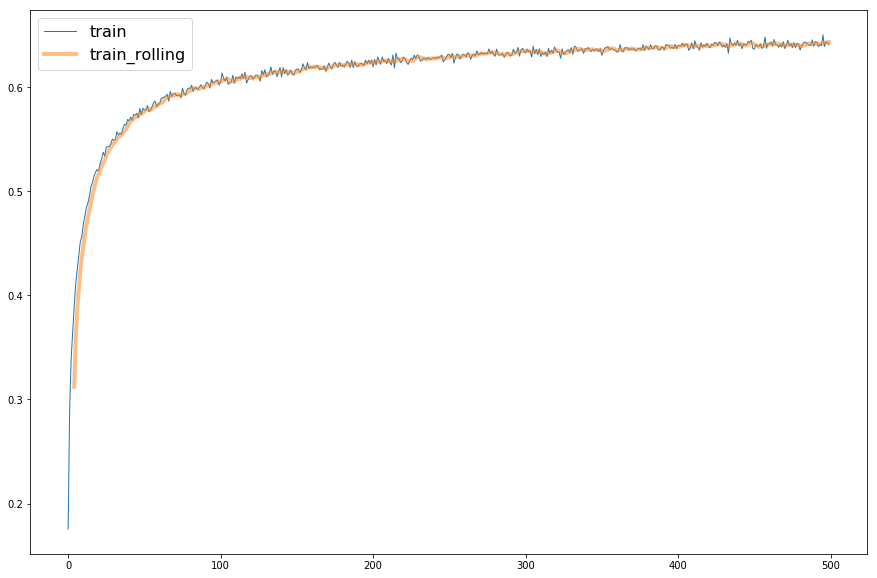

In [26]:
# 6b Append new values to a learning curve (extend epochs to see progress)
learn_curve_new = pd.DataFrame()
learn_curve_new['train'] = mod_history.history['acc']
learn_curve_new['train_rolling'] = pd.rolling_mean(learn_curve_new.train,window=5)
#append to previous df
learn_curve = learn_curve.append(learn_curve_new,ignore_index=True)
# Plot the learning curve
fig = plt.figure(figsize=(15, 10))
plt.plot(learn_curve['train'], lw=1, label='train')
plt.plot(learn_curve['train_rolling'], lw=4, label='train_rolling',alpha=.5)
plt.legend(loc='best', fontsize=16)

In [ ]:
# 7a Train Model (next 100 epochs with reduceLR on Plateau)

reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=1, patience=10, min_lr=1e-7)

mod_history = model.fit_generator(train_datagen.flow(traning_images_array, 
                                                    to_categorical(all_labels), 
                                                    batch_size=batch_size),
                                    steps_per_epoch=int(traning_images_array.shape[0]/batch_size),
                                    epochs=600, initial_epoch=500,
                                    verbose=1,
                                    class_weight=class_weights,
                                    callbacks = [reduceLR]
#                                     validation_data=val_generator,
#                                     validation_steps=int(validation_images_array.shape[0]/batch_size)+1
                                 )

/home/antonis/anaconda2/envs/kaggle/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


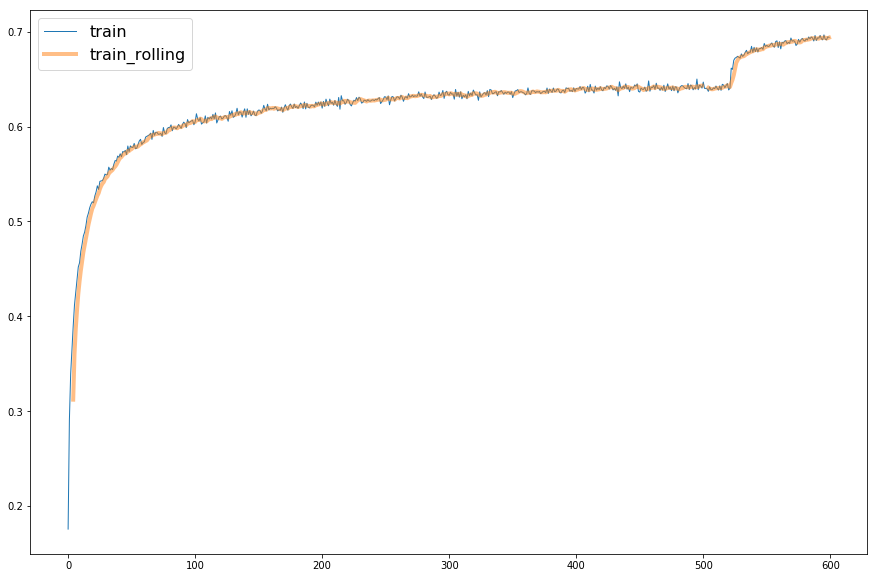

In [29]:
# 7b append new values to a learning curve (extend epochs to see progress)
learn_curve_new = pd.DataFrame()
learn_curve_new['train'] = mod_history.history['acc']
learn_curve_new['train_rolling'] = pd.rolling_mean(learn_curve_new.train,window=5)
#append to previous df
learn_curve = learn_curve.append(learn_curve_new,ignore_index=True)
# Plot the learning curve
fig = plt.figure(figsize=(15, 10))
plt.plot(learn_curve['train'], lw=1, label='train')
plt.plot(learn_curve['train_rolling'], lw=4, label='train_rolling',alpha=.5)
plt.legend(loc='best', fontsize=16)

In [ ]:
# 8a Train Model (next 50 epochs with reduceLR on Plateau - reduced patience/min_lr)

# steps_per_epoch should be (number of training images total / batch_size) 
# validation_steps should be (number of validation images total / batch_size)

reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=1, patience=5, min_lr=1e-14)

mod_history = model.fit_generator(train_datagen.flow(traning_images_array, 
                                                    to_categorical(all_labels), 
                                                    batch_size=batch_size),
                                    steps_per_epoch=int(traning_images_array.shape[0]/batch_size),
                                    epochs=650, initial_epoch=600,
                                    verbose=1,
                                    class_weight=class_weights,
                                    callbacks = [reduceLR]
                                    #validation_data=val_generator,
                                    #validation_steps=int(validation_images_array.shape[0]/batch_size)+1
                                 )


/home/antonis/anaconda2/envs/kaggle/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


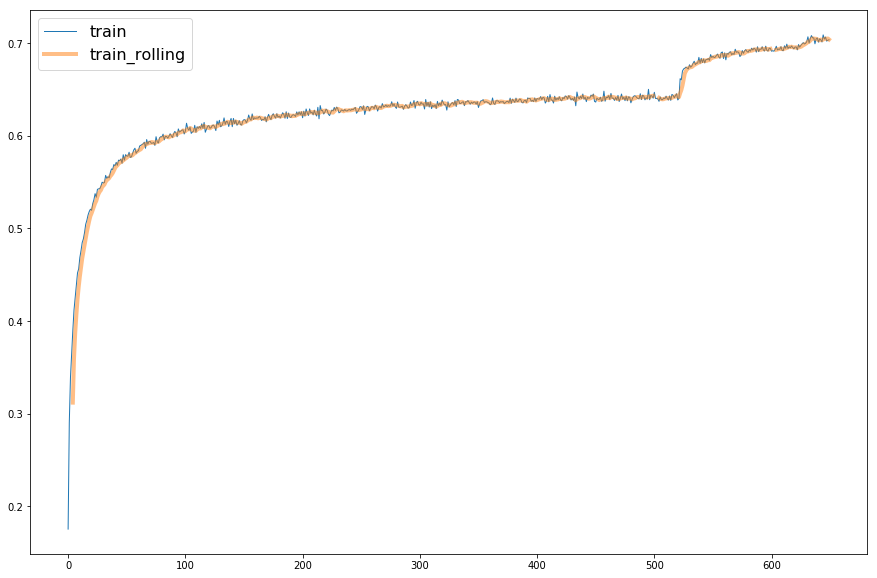

In [39]:
# 8b append new values to a learning curve (extend epochs to see progress)
learn_curve_new = pd.DataFrame()
learn_curve_new['train'] = mod_history.history['acc']
learn_curve_new['train_rolling'] = pd.rolling_mean(learn_curve_new.train,window=5)
#append to previous df
learn_curve = learn_curve.append(learn_curve_new,ignore_index=True)
# Plot the learning curve
fig = plt.figure(figsize=(15, 10))
plt.plot(learn_curve['train'], lw=1, label='train')
plt.plot(learn_curve['train_rolling'], lw=4, label='train_rolling',alpha=.5)
plt.legend(loc='best', fontsize=16)

# Export model (history, summary and learning curves)


In [49]:
# 9 Export model (history, summary and learning curves)

#set filename
notes='finalCountD2, 1DIVlog(x)'
time= datetime.now().strftime('%m-%d %H.%M, ')
errors = 'train_err=%.2f'%(mod_history.history['acc'][-1])
ffilename = 'trainHistory/'+time+errors+notes

notes='log'                    # add any notes here
with open(ffilename + '.pickle', 'wb') as file_pi:         # export model history
    pickle.dump(mod_history.history, file_pi)
model.save(ffilename+'.h5')                                # export model


with open(ffilename + '_summary.txt','w') as fh:           # save model summary (layer architecture etc)
    model.summary(print_fn=lambda x: fh.write(x + '\n'))   # Pass the file handle in as a lambda function to make it callable

fig.savefig(ffilename+'_learning_curve.png')               # save learning curve image

In [52]:
# 10 Test model

test_images_array = test_datagen.standardize(test_images_array)
results = model.predict(test_images_array, batch_size=batch_size, verbose=1)

6132/6132 [==============================] - 1s 125us/step


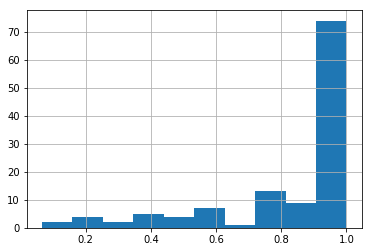

In [53]:
results_df = pd.DataFrame(results)
results_df.max(axis=0).hist()

In [54]:
# 11 Export submission .csv

results_df.index = map(lambda p: filename_from_path(test_set_list[p]), results_df.index)
subm = results_df.idxmax(axis=1)
#subm.head()
subm.to_csv(notes+'.csv',header=['class'],index_label='image')

40283.jpg      28
10858.jpg       8
153813.jpg     84
14182.jpg      45
59486.jpg     113
dtype: int64